In [64]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [65]:
df = pd.read_csv('daily-min-temperatures.csv')

In [66]:
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [68]:
#Parsing strings to datetime type
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
index_df = df.set_index(['Date'])

In [69]:
index_df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [8]:
from datetime import datetime

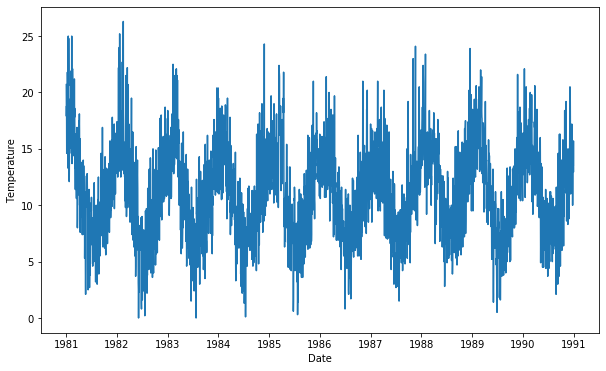

In [70]:
##plot graph 

plt.xlabel("Date")
plt.ylabel("Temperature")
plt.plot(index_df)

In [71]:
#Determining Rolling statistics
rolmean = index_df.rolling(window=365).mean()

rolstd = index_df.rolling(window=365).std()
print(rolmean,rolstd)

                 Temp
Date                 
1981-01-01        NaN
1981-01-02        NaN
1981-01-03        NaN
1981-01-04        NaN
1981-01-05        NaN
...               ...
1990-12-27  11.651507
1990-12-28  11.656712
1990-12-29  11.665205
1990-12-30  11.668767
1990-12-31  11.669589

[3650 rows x 1 columns]                 Temp
Date                
1981-01-01       NaN
1981-01-02       NaN
1981-01-03       NaN
1981-01-04       NaN
1981-01-05       NaN
...              ...
1990-12-27  3.856232
1990-12-28  3.857580
1990-12-29  3.858218
1990-12-30  3.861348
1990-12-31  3.861600

[3650 rows x 1 columns]


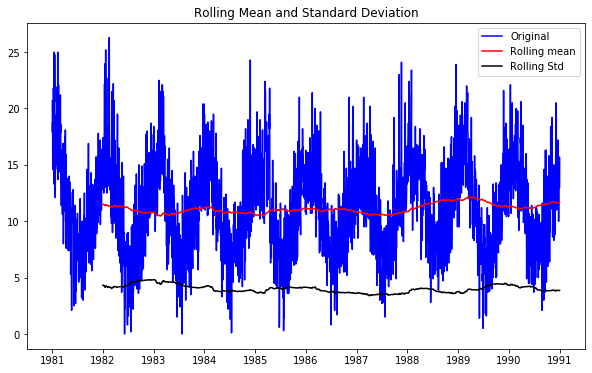

In [72]:
#Plotting rolling statistics

orig = plt.plot(index_df,color="blue",label='Original')
mean = plt.plot(rolmean,color="red",label='Rolling mean')
std = plt.plot(rolstd,color="black",label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

In [73]:
#Performing Dickey-Fuller  test

from statsmodels.tsa.stattools import adfuller

print("Result of Dickey-Fuller test:")
df_test = adfuller(index_df['Temp'],autolag='AIC')

df_output = pd.Series(df_test[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in df_test[4].items():
    df_output['Critical Value (%s)' %key] = value

print(df_output)

Result of Dickey-Fuller test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


We can see that the p value is very much less , However slight variation with Test Statistic and Critical Value

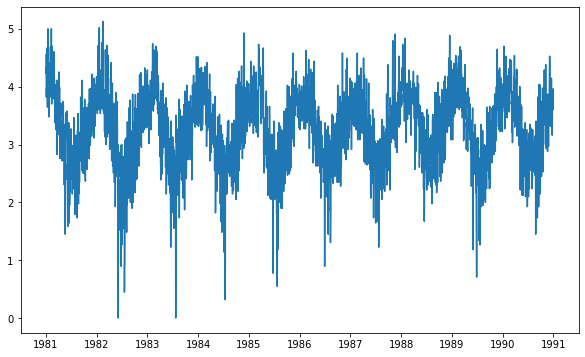

In [92]:
#Estimating trend
index_df_logScale = np.sqrt(index_df)
index_df_logScale.dropna(inplace=True)
plt.plot(index_df_logScale)

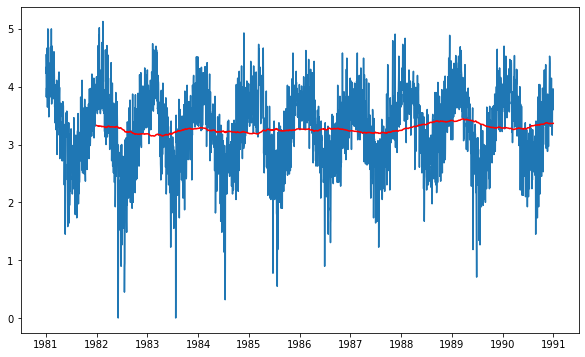

In [75]:
movingAverage = index_df_logScale.rolling(window=365).mean()
movingSTD = index_df_logScale.rolling(window=365).std()
plt.plot(index_df_logScale)
plt.plot(movingAverage,color="red")

In [76]:
df_logScaleMinusmovingAvg = index_df_logScale - movingAverage
df_logScaleMinusmovingAvg.head(365)

,Temp
Date,
1981-01-01,NaN
1981-01-02,NaN
1981-01-03,NaN
1981-01-04,NaN
1981-01-05,NaN
...,...
1981-12-27,NaN
1981-12-28,NaN
1981-12-29,NaN


In [77]:
#Remove NaN values
df_logScaleMinusmovingAvg.dropna(inplace=True)


In [78]:
#Function for making Stationery

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determining rolling Statistics
    movingAverage = timeseries.rolling(window=365).mean()
    movingSTD = timeseries.rolling(window=365).std()
    
    #Plot rolling statistics
    orig =plt.plot(timeseries,color="blue",label='Original')
    mean = plt.plot(movingAverage,color="red",label='Rolling Mean')
    std = plt.plot(movingSTD,color="black",label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Performing Dickey-Fuller test
    print('Results of Dickey Fuller Test :')
    df_test = adfuller(timeseries['Temp'],autolag='AIC')
    df_output = pd.Series(df_test[0:4],index=['Test Statistics','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical value (%s)' %key] = value
    print(df_output)
    

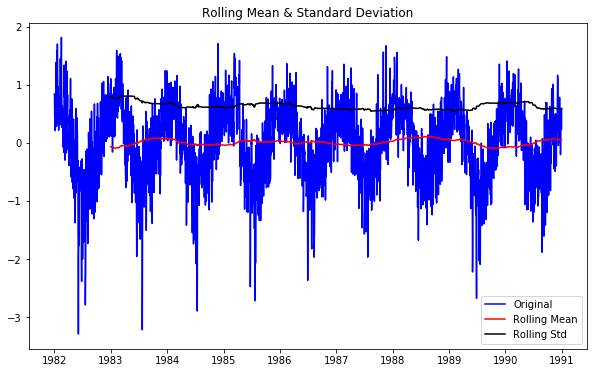

Results of Dickey Fuller Test :
Test Statistics                  -3.731584
p-value                           0.003690
#Lags Used                       25.000000
Number of Observations Used    3260.000000
Critical value (1%)              -3.432358
Critical value (5%)              -2.862427
Critical value (10%)             -2.567242
dtype: float64


In [79]:
test_stationarity(df_logScaleMinusmovingAvg)

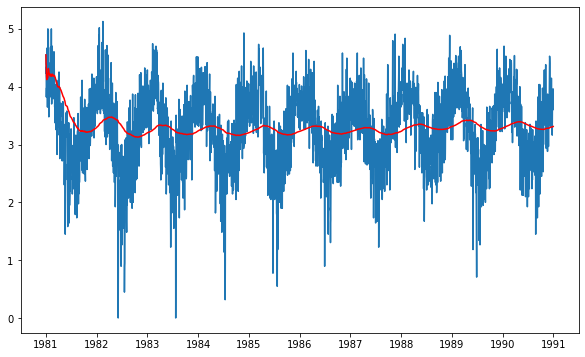

In [80]:
exponentialWeightedAvg = index_df_logScale.ewm(halflife=365,min_periods=0,adjust=True).mean()
plt.plot(index_df_logScale)
plt.plot(exponentialWeightedAvg,color="red")

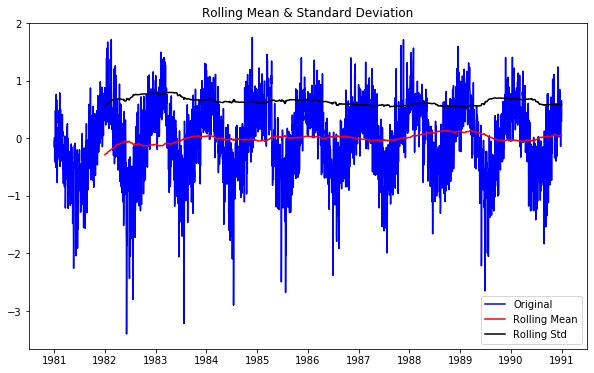

Results of Dickey Fuller Test :
Test Statistics                  -3.649570
p-value                           0.004881
#Lags Used                       25.000000
Number of Observations Used    3624.000000
Critical value (1%)              -3.432156
Critical value (5%)              -2.862338
Critical value (10%)             -2.567195
dtype: float64


In [81]:
df_logScaleMinusexpWeightedAvg = index_df_logScale - exponentialWeightedAvg
df_logScaleMinusexpWeightedAvg.dropna(inplace=True)
test_stationarity(df_logScaleMinusexpWeightedAvg)

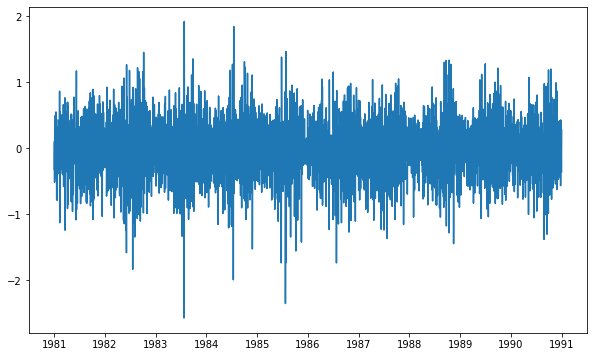

In [82]:
df_logDiffShifting = index_df_logScale - index_df_logScale.shift()
plt.plot(df_logDiffShifting)

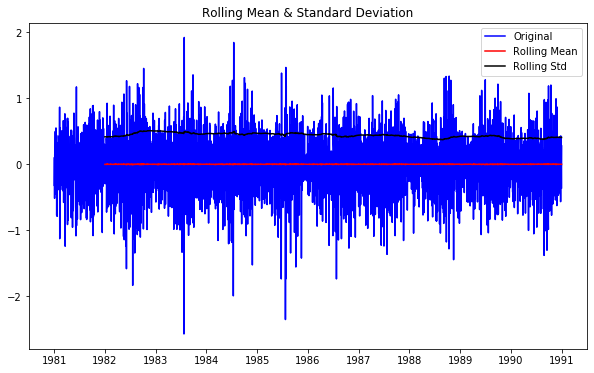

Results of Dickey Fuller Test :
Test Statistics               -1.859855e+01
p-value                        2.070254e-30
#Lags Used                     2.400000e+01
Number of Observations Used    3.624000e+03
Critical value (1%)           -3.432156e+00
Critical value (5%)           -2.862338e+00
Critical value (10%)          -2.567195e+00
dtype: float64


In [83]:
df_logDiffShifting.dropna(inplace=True)
test_stationarity(df_logDiffShifting)

In [93]:
index_df_logScale.head()

,Temp
Date,
1981-01-01,4.549725
1981-01-02,4.230839
1981-01-03,4.335897
1981-01-04,3.820995
1981-01-05,3.974921


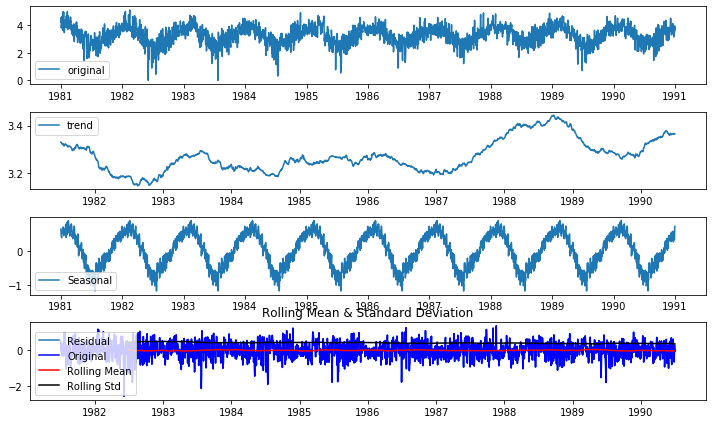

Results of Dickey Fuller Test :


KeyError: 'Temp'

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(index_df_logScale,period=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(index_df_logScale,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)
    

D:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


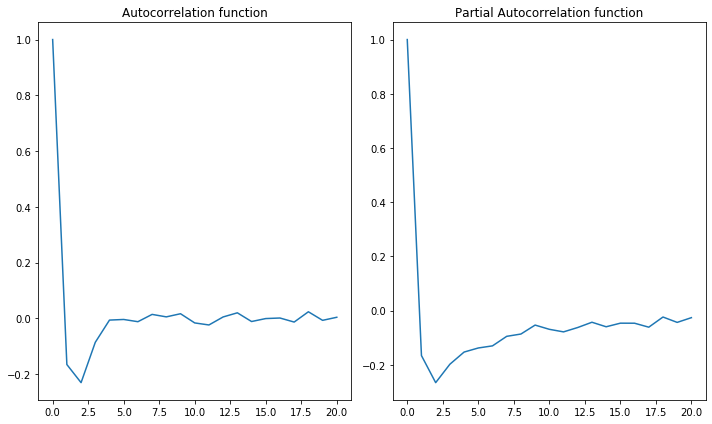

In [97]:
#ACF and #PCF plots
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(df_logDiffShifting,nlags=20)
lag_pacf = pacf(df_logDiffShifting,nlags=20,method ='ols')

# Plotiing ACF 

plt.subplot(121)
plt.plot(lag_acf)
#plt.axhline(y=0,linestyle='--',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(df_logDiffShifting)),linestyle='--',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(df_logDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation function')

# Plotiing PACF 

plt.subplot(122)
plt.plot(lag_pacf)
#plt.axhline(y=0,linestyle='--',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(df_logDiffShifting)),linestyle='--',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(df_logDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation function')
plt.tight_layout()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting AR Model


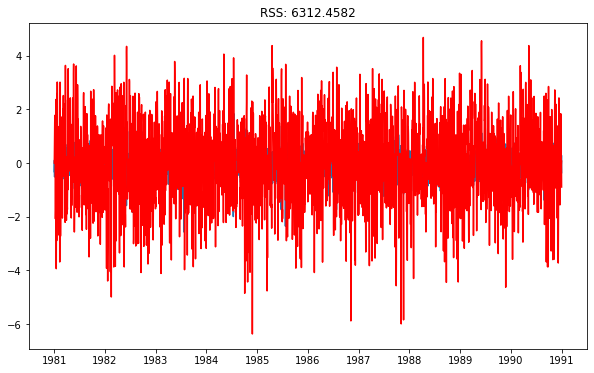

In [100]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL

model =ARIMA(index_df,order=(0,1,2))
results_AR = model.fit(disp=-1)
plt.plot(df_logDiffShifting)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_logDiffShifting['Temp'])**2))
print('Plotting AR Model')

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting MA Model


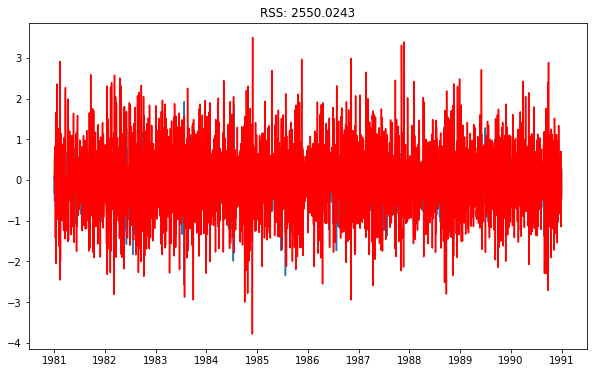

In [101]:
#MA MODEL

model =ARIMA(index_df,order=(2,1,0))
results_MA = model.fit(disp=-1)
plt.plot(df_logDiffShifting)
plt.plot(results_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-df_logDiffShifting['Temp'])**2))
print('Plotting MA Model')

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting ARIMA Model


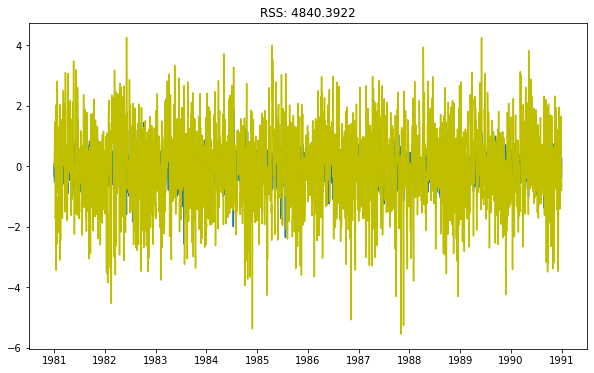

In [103]:
#ARIMA MODEL

model =ARIMA(index_df,order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(df_logDiffShifting)
plt.plot(results_ARIMA.fittedvalues,color='y')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_logDiffShifting['Temp'])**2))
print('Plotting ARIMA Model')

In [104]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head())

Date
1981-01-02   -0.001205
1981-01-03    0.505477
1981-01-04    0.525081
1981-01-05    1.467752
1981-01-06    1.360114
dtype: float64


In [106]:
#Convert to Cumilative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())


Date
1981-01-02   -0.001205
1981-01-03    0.504272
1981-01-04    1.029354
1981-01-05    2.497105
1981-01-06    3.857219
dtype: float64


In [117]:
predictions_ARIMA_log =  pd.Series(index_df_logScale['Temp'][0],index=index_df_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1981-01-01    4.549725
1981-01-02    4.548520
1981-01-03    5.053998
1981-01-04    5.579079
1981-01-05    7.046831
dtype: float64

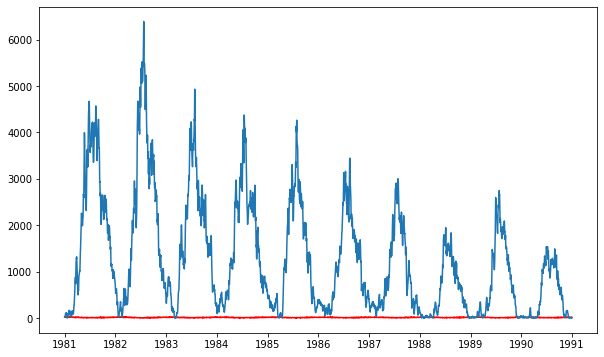

In [122]:
predictions_ARIMA = np.square(predictions_ARIMA_log)
plt.plot(index_df,color='red')
plt.plot(predictions_ARIMA)

In [123]:
predictions_ARIMA.head()

Date
1981-01-01    20.700000
1981-01-02    20.689036
1981-01-03    25.542892
1981-01-04    31.126122
1981-01-05    49.657824
dtype: float64

In [130]:
index_df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [128]:
#results_ARIMA.plot_predict(1,3750)
x=results_ARIMA.forecast(steps=100)

In [129]:
x

(array([13.08939938, 13.48742004, 13.66869495, 13.70642213, 13.70142814,
        13.69354499, 13.68957004, 13.68785086, 13.6867406 , 13.68564544,
        13.68448193, 13.68328336, 13.68207628, 13.68086943, 13.67966374,
        13.67845859, 13.67725356, 13.67604852, 13.67484346, 13.67363839,
        13.67243331, 13.67122824, 13.67002317, 13.6688181 , 13.66761303,
        13.66640796, 13.66520289, 13.66399782, 13.66279275, 13.66158768,
        13.66038261, 13.65917754, 13.65797247, 13.65676739, 13.65556232,
        13.65435725, 13.65315218, 13.65194711, 13.65074204, 13.64953697,
        13.6483319 , 13.64712683, 13.64592176, 13.64471669, 13.64351162,
        13.64230655, 13.64110148, 13.63989641, 13.63869133, 13.63748626,
        13.63628119, 13.63507612, 13.63387105, 13.63266598, 13.63146091,
        13.63025584, 13.62905077, 13.6278457 , 13.62664063, 13.62543556,
        13.62423049, 13.62302542, 13.62182034, 13.62061527, 13.6194102 ,
        13.61820513, 13.61700006, 13.61579499, 13.6